In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%load_ext tensorboard


In [59]:
!wget https://raw.githubusercontent.com/Nik0la-i/intro-to-dl/master/setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week2()

--2021-08-25 20:46:02--  https://raw.githubusercontent.com/Nik0la-i/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py.2’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2021-08-25 20:46:02 (60.9 MB/s) - ‘setup_google_colab.py.2’ saved [3636/3636]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


# Intro to TensorFlow

This notebook covers the basics of TF and shows you an animation with gradient descent trajectory.
<img src="https://github.com/Nik0la-i/intro-to-dl/blob/master/week2/v2/images/gradient_descent.png?raw=1" style="width:50%">

# TensorBoard

**Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there.**

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [8]:
import tensorflow as tf
import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)




We're using TF 1.15.2


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [9]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [10]:
%%time
sum_python(10**5)

CPU times: user 1.94 ms, sys: 327 µs, total: 2.27 ms
Wall time: 5.36 ms


333328333350000

# Tensoflow teaser

Doing the very same thing

In [11]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [12]:
# just a graph definition
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [13]:
%%time
# actually executing
result.eval({N: 10**5})

CPU times: user 9.71 ms, sys: 1.54 ms, total: 11.3 ms
Wall time: 69.7 ms


333328333350000

In [14]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [16]:
np.cos(-9)

-0.9111302618846769

In [17]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [18]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [19]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [20]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [25]:
with tf.Session() as s:
  #s.run(tf.global_variables_initializer())
  print(s.run(my_transformation, {my_vector: dummy, my_vector2: dummy[::-1]}))

[0.        1.6291324 2.0950115 2.6289961 0.       ]


In [21]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [26]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    # mse = ### YOUR CODE HERE ###
    mse = tf.reduce_mean((y_true - y_predicted) ** 2)

def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [27]:
writer.add_graph(mse.graph)
writer.flush()

In [30]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')


# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [52]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

In [40]:
s = tf.InteractiveSession()
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [1. 1. 1. 1. 1.]


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [53]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


In [36]:
s.close()

# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [47]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [38]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

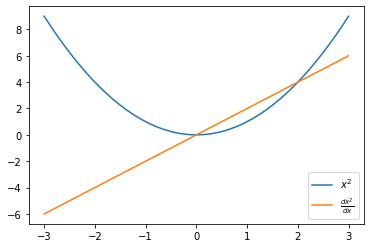

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [55]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

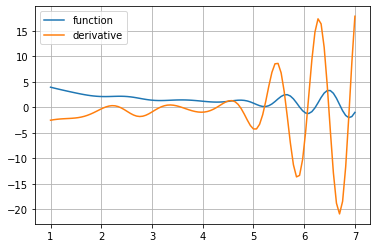

In [56]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [57]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

Let's draw a trajectory of a gradient descent in 2D

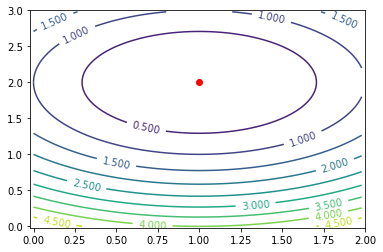

In [60]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [61]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the build-in renderers are unaviable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABO1m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAADI+ZYiE
ACv//vZzfAprRzOVLgV292aj5dCS5fsQYPrQAAADAAGq1jzipe3VQKREMzn+ud2GzbOJ43BPcMYj
i93Y+Em0ioSb+61aEWEM7dcbRaivTOm4o+VA8ddAAAAFKlUSisUnKcUIhincww6T5PkKpaK19RDU
XBPH/pmpmIqHtCYyZf8TZNeLqtLPBRS0zroJvm/0WhHZqHT4sVJ1A0QYyaRH3tm9j8pH6isGYwLm
p80b8MFL5upDVMndNVIe0lPtZtq21Dpj84mws4mZKNEZVvfHjNmlvtN2GMNO5l4ylcOc33zCq1wk
LPnp9m84I6D4NP3kYl7Qq59cuOH75TPx64OS7N4Z0DPeUwuOKqaVoPrXKk4mlhXQrU6jhfvC6QjJ
cQhID7TroGsiNeMxdj8GZGCcPPTtxLa0QEWdQjVZEBd4+mMYwV/aOk2fsfT57cp18uVynvzjd/Eh
E81ZKCMtDSiVmpEUsM143oeaGZxPgU5d+UImDim3Kf9X6RiArcbric5Rhm+DjNnncfDklslLzSH4
o5ikhdkEjH491aNhpc96SiUcMErPRih5z+TUfhvZSoCJFl+5eJCYjlJ4Gru7LQf7d3M4lHcjjcZP
magiNyPja5G+MwpcF5+QwdE1XnMUcOLtFxgWuJbuPlXjjh/48o6kKsls5by4V8xeDWf6a89zSK0n
YT4qUZhw1ppSO/Z0rdcf+Pj5fvJI1Qx3b72qFnH9ANCQ5JgTOxcCgR69zhsBlnSI2YRrVse2RzDK
btG61oFziQCzb1Zv2CyGFe1F6K7laxnL1rBTNbgIbAIPamqn1dqWqA5U+O9UpQKI6l+RcdvbKlhU
N5SLOZj5tAsL75sLJpSiG14HVL+be/bM3Bz2u2iWUKY28dLQkHLejAn9Wp+4N+WDEOrJv6g3S0zJ
vJhy227JUNMVISDm58faibtO8S8avxs3/VA65hFNo9zbKnY/cVNd9bsRIDAZE8kGOKzOVJwS423k
nkjdG1V17N2S2TBrpNHpQMSqZ40y1lEXepbWzdgHDFA7zrDbDg2dIbp2jo+MbeWlOwYn2e47my8A
dv2A8sY/kc1BXtGx+5sWlQs8x6dZZjnamqjjd8JPYNeB59WIQUJRYqYakVfilNBrJaYHEXHrmU4e
wCi37Aw6vt0BP0ZxDboAvcGkebH1nDHsFLr2weQOSSQyBn+5xj8oxi7tFAe13LCVZ+5coBc/PWsr
QcbmO7B4S5dd3vxBL3baZDsEJligYDRbM1gZO930T2U0v/kYJ3ztOjRw9XrcA7YjNn1kPYJr/bxP
amVkcN1B0uYgxMET6367rDt2jeO7ggdQ/aVMQUFSUuWHnVRwufJ9qeskqzufbmIrgUMEQeokz1u5
Ac3xCC1wK0m+i6hz9jjDUgm7SseFnjM/skXKVMLodvUQcRABO5KZWFPAhwsm7KqsJfqVIF/Mt+Uu
w/8ZwUn23OdZOJiaZLtTCsJWROe4tJdSvHaAJ8R44K/IZWIh/zkUGaKcKsAhwlvaMyhzzJnjyQqE
49Xl9si8bEANZ43iJgr6dupi9ZemmXAwnL+I6A0sUQ1i2E7+i1lgjHwhEfT0sN2WkKZpv/ABtR2O
0lg5Hm7cl+LPq2IGf3p6su5C0y061d4hXiB0Sz/dsbR8od8n/Ocy0vd9DdOemY+4Ts3IG269/y0o
aMSBsXo0m7F2BWfaKOT5AsvR4y5HzM1Fn3PTlRb1MJvtvRWlwyywnLO0FR6Q9dqnFfzbK+LqwtPg
g2kAOWpFpyZqquzdxZ5gt8iTwYHIZvSVQF/owfFgP03+Wz4KrIWcvAs8JUj4wDO4L8FVucx/YDSC
pC27a837HYaNioOzt1timLBjYBJIsQGiXvOR5Urh88HlVCDxAcB0Kql80DBfeFwLixMwToED/Syi
1kDudVLbfPUhItNw2AwaTFgu35tSwEiGA1SFWhZNNCSEsBbHFMTV9BUeclTw0bDkAgu2STlpLgMJ
wCH3m1RdBTagkqHvS/ZoxdRdiLr7OS9dxZbCXpPNGmooaB23CrrtXzYrUazlsDRZSh/RrLIyDfBi
8vF6quaEq9Yz/pWwoMH/BqB/iS73KwTn15v503d4sIqh1dE8OVfyN4aDoldjWrwKB76T40DaLKVh
XDtMmLAgKX1VZ21aYuCw/QQ5ZzTWD8nCHMumHcV94pj9IPXpkgtesLUjcHiZBaNELbPkc2O+qyu/
//7KwW1t5MXPsZRWeGLzRm9QomEl5tu7t3JUADTESttZNo+zcqFCVXz29xqr3aXvF/RVelHPYGF/
+8DxzBklvrYmAKnaeJbKuizzjZKCfWtWRzkjgYNCX8+1nKwgvDV1FykaUG76ieUggZXft/SgXDts
rYNlnO642XSr7IisX3j2tnvpXLPl0SfPCpGVUy+5RkHmjkiEIoQC4pcxTx0lq1Al+GuTPO2+p1PJ
hhDB796j4Zo/MfNmt/8tQvIB/QHC7PV0AwegtbaGmWTCMijLaTok5VQFERylQoXt4UhABKirRWZT
dLWs83EzNywETwtE2msOsWBXKW1XeuCYccIuNUvKZxCEBoZRL+4DyiWGDoOjP0Wcq5xzfvl2WQVu
iBBKosalAJMjgcyg9tRaRvzvd+49SuqyVqaJOECq5L37lIbJbAvenFJbdg/CdFqadUZ0uVBzF2Pl
vrXmEij2F8FkE2pqlUqQaEmwo9uOs1miNhjtJoXugV9onVCIAYuZFOg/Ps+W4RvnnmV3kc95AWsl
Q+PpENUH2VI70x4b0yLzMR/a0YmWoYvVXPQLHO2ARF5ykoIRTuYzQqfLSArzOnW0AdqeVrsHp43Q
2dsataI/v+7ZJALZHyLVWMH/y7r5Ie4PfbbvZEU9hMtBtccoIlHAqj59OB1FrtpHDa+qZ12kI36v
pEiYv/SO2FLZv7hZhAOcq